In [2]:
!pip install scanpy

Defaulting to user installation because normal site-packages is not writeable


In [3]:
import scanpy as sc

In [4]:
!pip install scvi-tools

Defaulting to user installation because normal site-packages is not writeable


In [5]:
import scvi

/home/sunag/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
import seaborn as sns

In [8]:
ribo_url = "http://software.broadinstitute.org/gsea/msigdb/download_geneset.jsp?geneSetName=KEGG_RIBOSOME&fileType=txt"

In [9]:
ribo_genes = pd.read_table(ribo_url, skiprows=2, header = None)
ribo_genes

,0
0,FAU
1,MRPL13
2,RPL10
3,RPL10A
4,RPL10L
...,...
83,RPS9
84,RPSA
85,RSL24D1
86,RSL24D1P11


In [10]:
import numpy as np

In [11]:
!pip install leidenalg

Defaulting to user installation because normal site-packages is not writeable


# Doublet removal, Preprocessing, Normalization, Clustering and Integration

In [12]:
def pp(csv_path):
    adata = sc.read_csv(csv_path).T
    sc.pp.filter_genes(adata, min_cells = 10)
    sc.pp.highly_variable_genes(adata, n_top_genes = 2000, subset = True, flavor = 'seurat_v3')
    scvi.model.SCVI.setup_anndata(adata)
    vae = scvi.model.SCVI(adata)
    vae.train()
    solo = scvi.external.SOLO.from_scvi_model(vae)
    solo.train()
    df = solo.predict()
    df['prediction'] = solo.predict(soft = False)
    df.index = df.index.map(lambda x: x[:-2])
    df['dif'] = df.doublet - df.singlet
    doublets = df[(df.prediction == 'doublet') & (df.dif > 1)]
    
    adata = sc.read_csv(csv_path).T
    adata.obs['Sample'] = csv_path.split('_')[2] #'raw_counts/GSM5226574_C51ctr_raw_counts.csv'
    
    adata.obs['doublet'] = adata.obs.index.isin(doublets.index)
    adata = adata[~adata.obs.doublet]
    
    
    sc.pp.filter_cells(adata, min_genes=200) #get rid of cells with fewer than 200 genes
    #sc.pp.filter_genes(adata, min_cells=3) #get rid of genes that are found in fewer than 3 cells
    adata.var['mt'] = adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
    adata.var['ribo'] = adata.var_names.isin(ribo_genes[0].values)
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt', 'ribo'], percent_top=None, log1p=False, inplace=True)
    upper_lim = np.quantile(adata.obs.n_genes_by_counts.values, .98)
    adata = adata[adata.obs.n_genes_by_counts < upper_lim]
    adata = adata[adata.obs.pct_counts_mt < 20]
    adata = adata[adata.obs.pct_counts_ribo < 2]

    return adata

In [13]:
import os

In [14]:
out = []
for file in os.listdir('/home/sunag/Downloads/scRNA_seq/'):
    out.append(pp('/home/sunag/Downloads/scRNA_seq/' + file))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/sunag/.local/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 400/400: 100%|██████████| 400/400 [03:16<00:00,  2.05it/s, v_num=1, train_loss_step=328, train_loss_epoch=326]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [03:16<00:00,  2.04it/s, v_num=1, train_loss_step=328, train_loss_epoch=326]
INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/sunag/.local/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/sunag/.local/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 244/400:  61%|██████    | 244/400 [00:33<00:21,  7.34it/s, v_num=1, train_loss_step=0.372, train_loss_epoch=0.256]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.231. Signaling Trainer to stop.


/home/sunag/.local/lib/python3.10/site-packages/torch/utils/_contextlib.py:115: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/home/sunag/.local/lib/python3.10/site-packages/torch/utils/_contextlib.py:115: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/home/sunag/.local/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:166: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number
GPU availa

Epoch 400/400: 100%|██████████| 400/400 [02:17<00:00,  2.92it/s, v_num=1, train_loss_step=350, train_loss_epoch=332]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [02:17<00:00,  2.92it/s, v_num=1, train_loss_step=350, train_loss_epoch=332]
INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/sunag/.local/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/sunag/.local/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 400/400: 100%|██████████| 400/400 [00:41<00:00,  9.92it/s, v_num=1, train_loss_step=0.432, train_loss_epoch=0.272]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [00:41<00:00,  9.59it/s, v_num=1, train_loss_step=0.432, train_loss_epoch=0.272]


/home/sunag/.local/lib/python3.10/site-packages/torch/utils/_contextlib.py:115: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/home/sunag/.local/lib/python3.10/site-packages/torch/utils/_contextlib.py:115: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/home/sunag/.local/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:166: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number


In [15]:
adata = sc.concat(out)

In [16]:
adata

AnnData object with n_obs × n_vars = 6856 × 34546
    obs: 'Sample', 'doublet', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'

In [17]:
sc.pp.filter_genes(adata, min_cells = 10)

In [18]:
adata.X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 2.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [19]:
from scipy.sparse import csr_matrix

In [20]:
adata.X = csr_matrix(adata.X)

In [21]:
adata.X

<6856x19549 sparse matrix of type '<class 'numpy.float32'>'
	with 5697221 stored elements in Compressed Sparse Row format>

In [22]:
adata.write_h5ad('combined.h5ad')

In [ ]:
########################################################

In [23]:
import scanpy as sc
import scvi
import seaborn as sns
import numpy as np
import pandas as pd

In [24]:
adata = sc.read_h5ad('combined.h5ad')
adata

AnnData object with n_obs × n_vars = 6856 × 19549
    obs: 'Sample', 'doublet', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'n_cells'

In [25]:
adata.obs.groupby('Sample').count()

/tmp/ipykernel_3551/2340059915.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata.obs.groupby('Sample').count()


,doublet,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo
Sample,,,,,,,,
C56ctr,3904,3904,3904,3904,3904,3904,3904,3904
L01cov,2952,2952,2952,2952,2952,2952,2952,2952


In [26]:
sc.pp.filter_genes(adata, min_cells = 100)

In [27]:
adata

AnnData object with n_obs × n_vars = 6856 × 10162
    obs: 'Sample', 'doublet', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'n_cells'

In [28]:
adata.layers['counts'] = adata.X.copy()

In [29]:
sc.pp.normalize_total(adata, target_sum = 1e4)
sc.pp.log1p(adata)
adata.raw = adata

In [30]:
adata.obs.head()

,Sample,doublet,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo
GCCCGAATCACTCGAA-1_6,C56ctr,False,2740,2740,6221.0,0.0,0.0,1.0,0.016075
GAGTCATTCTGTCAGA-1_6,C56ctr,False,2426,2426,5828.0,0.0,0.0,0.0,0.000000
GTTACGATCCAGTACA-1_6,C56ctr,False,2724,2724,6071.0,0.0,0.0,1.0,0.016472
CCTGCATTCGGACAAG-1_6,C56ctr,False,2678,2678,5821.0,0.0,0.0,3.0,0.051538
AGGGCTCTCATGCCCT-1_6,C56ctr,False,2742,2742,5527.0,0.0,0.0,0.0,0.000000


In [31]:
adata

AnnData object with n_obs × n_vars = 6856 × 10162
    obs: 'Sample', 'doublet', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'n_cells'
    uns: 'log1p'
    layers: 'counts'

In [ ]:
# sc.pp.highly_variable_genes(adata, n_top_genes=3000, subset = True, layer = 'counts',
#                            flavor = "seurat_v3", batch_key="Sample") #no batch_key if one sample

In [32]:
scvi.model.SCVI.setup_anndata(adata, layer = "counts",
                             categorical_covariate_keys=["Sample"],
                             continuous_covariate_keys=['pct_counts_mt', 'total_counts', 'pct_counts_ribo'])

In [33]:
model = scvi.model.SCVI(adata)

In [34]:
model.train() #may take a while without GPU

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/sunag/.local/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 400/400: 100%|██████████| 400/400 [30:51<00:00,  4.54s/it, v_num=1, train_loss_step=2.59e+3, train_loss_epoch=2.42e+3]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [30:51<00:00,  4.63s/it, v_num=1, train_loss_step=2.59e+3, train_loss_epoch=2.42e+3]


In [35]:
adata.obsm['X_scVI'] = model.get_latent_representation()

In [36]:
adata.layers['scvi_normalized'] = model.get_normalized_expression(library_size = 1e4)

In [37]:
sc.pp.neighbors(adata, use_rep = 'X_scVI')

In [38]:
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution = 0.5)

/tmp/ipykernel_3551/4004962361.py:2: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution = 0.5)


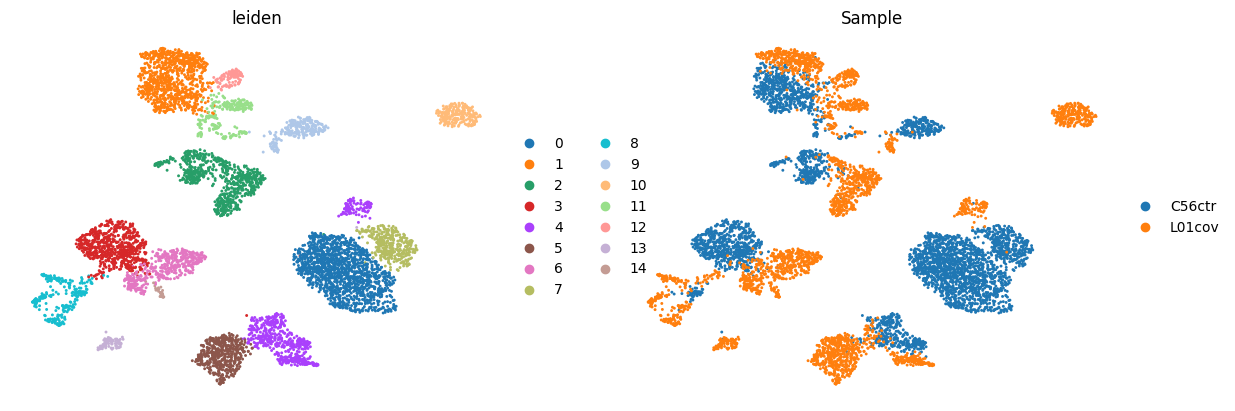

In [39]:
sc.pl.umap(adata, color = ['leiden', 'Sample'], frameon = False)

In [40]:
adata.write_h5ad('integrated.h5ad')

# Find markers/ label cell types

In [41]:
sc.tl.leiden(adata, resolution = 1)

In [42]:
sc.tl.rank_genes_groups(adata, 'leiden')

/home/sunag/.local/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:435: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "names"] = self.var_names[global_indices]
/home/sunag/.local/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:437: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "scores"] = scores[global_indices]
/home/sunag/.local/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:440: PerformanceWarning: DataFrame is highly fragmented.  Th

In [ ]:
#sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)

In [43]:
markers = sc.get.rank_genes_groups_df(adata, None)
markers = markers[(markers.pvals_adj < 0.05) & (markers.logfoldchanges > .5)]
markers

,group,names,scores,logfoldchanges,pvals,pvals_adj
0,0,PTPRN2,63.498009,5.064967,0.000000e+00,0.000000e+00
1,0,LINC01876,59.553783,4.646091,0.000000e+00,0.000000e+00
2,0,LINC00342,58.007633,5.101126,0.000000e+00,0.000000e+00
3,0,ANKRD36C,53.323986,4.757200,0.000000e+00,0.000000e+00
4,0,GMDS,52.908955,4.506167,2.454136e-316,8.906761e-314
...,...,...,...,...,...,...
203441,20,TBX5,2.321783,3.449696,2.676065e-02,4.563546e-02
203442,20,TASP1,2.319985,1.861507,2.685481e-02,4.577299e-02
203443,20,PALLD,2.317352,1.520778,2.699572e-02,4.600544e-02
203444,20,NAV2,2.305161,1.513135,2.775652e-02,4.723861e-02


In [44]:
markers_scvi = model.differential_expression(groupby = 'leiden')
markers_scvi

DE...: 100%|██████████| 21/21 [01:03<00:00,  3.03s/it]


,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,...,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05,comparison,group1,group2
NOX1,0.9954,0.0046,5.377086,2.642620e-04,0.000008,0.0,0.25,8.394108,8.504955,3.688667,...,0.496209,0.009439,0.280607,0.008090,3.409057,0.073391,True,0 vs Rest,0,Rest
PRKY,0.9928,0.0072,4.926447,9.651420e-07,0.000148,0.0,0.25,-6.718639,-7.255180,3.269622,...,0.000000,0.127591,0.000000,0.099781,0.000000,1.336581,True,0 vs Rest,0,Rest
FLNA,0.9926,0.0074,4.898846,4.015479e-07,0.000179,0.0,0.25,-8.555083,-9.304348,4.059710,...,0.000000,0.165345,0.000000,0.129614,0.000000,1.640171,True,0 vs Rest,0,Rest
MTSS1,0.9912,0.0088,4.724163,3.583157e-06,0.000246,0.0,0.25,-5.828792,-6.086389,2.832655,...,0.000000,0.174447,0.000000,0.105006,0.000000,1.845287,True,0 vs Rest,0,Rest
SYN2,0.9908,0.0092,4.679308,1.333786e-04,0.000008,0.0,0.25,6.136240,6.173307,3.236570,...,0.188516,0.005899,0.126761,0.005394,1.238785,0.043975,True,0 vs Rest,0,Rest
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
IQGAP1,0.6420,0.3580,0.584055,3.496476e-04,0.000344,0.0,0.25,0.057793,0.098058,0.562159,...,0.363636,0.454646,0.303030,0.320827,4.210152,3.909011,False,20 vs Rest,20,Rest
MARK3,0.6390,0.3610,0.571026,4.205664e-04,0.000440,0.0,0.25,0.011572,0.037258,0.576573,...,0.181818,0.538482,0.151515,0.365528,1.948140,4.646190,False,20 vs Rest,20,Rest
BIRC6,0.6292,0.3708,0.528786,4.972499e-04,0.000506,0.0,0.25,0.023840,0.030602,0.510890,...,0.454545,0.694576,0.303030,0.439103,5.106672,6.213936,False,20 vs Rest,20,Rest
NIPBL,0.6006,0.3994,0.407966,5.482138e-04,0.000571,0.0,0.25,-0.010858,-0.011924,0.469714,...,0.515152,0.701465,0.454545,0.443940,8.473536,6.214753,False,20 vs Rest,20,Rest


In [45]:
markers_scvi = markers_scvi[(markers_scvi['is_de_fdr_0.05']) & (markers_scvi.lfc_mean > .5)]
markers_scvi

,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,...,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05,comparison,group1,group2
NOX1,0.9954,0.0046,5.377086,0.000264,0.000008,0.0,0.25,8.394108,8.504955,3.688667,...,0.496209,0.009439,0.280607,0.008090,3.409057,0.073391,True,0 vs Rest,0,Rest
SYN2,0.9908,0.0092,4.679308,0.000133,0.000008,0.0,0.25,6.136240,6.173307,3.236570,...,0.188516,0.005899,0.126761,0.005394,1.238785,0.043975,True,0 vs Rest,0,Rest
GPX2,0.9902,0.0098,4.615524,0.000134,0.000005,0.0,0.25,7.102087,6.711297,4.379107,...,0.211267,0.006236,0.169014,0.005731,1.381710,0.050697,True,0 vs Rest,0,Rest
REG4,0.9896,0.0104,4.555494,0.000335,0.000038,0.0,0.25,8.323160,8.512503,4.671793,...,0.393283,0.043823,0.212351,0.019215,2.822461,0.283858,True,0 vs Rest,0,Rest
MGAM2,0.9894,0.0106,4.536244,0.000334,0.000033,0.0,0.25,7.583597,7.395989,4.360820,...,0.529795,0.041631,0.331528,0.024271,3.751011,0.283589,True,0 vs Rest,0,Rest
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NAMPT,0.9118,0.0882,2.335814,0.000880,0.000623,0.0,0.25,1.252292,1.163618,2.140870,...,0.757576,0.679180,0.363636,0.264986,10.761639,6.101663,True,20 vs Rest,20,Rest
RBM12,0.9118,0.0882,2.335814,0.000061,0.000026,0.0,0.25,1.458999,1.422764,1.690454,...,0.030303,0.021691,0.030303,0.021398,0.338203,0.193642,True,20 vs Rest,20,Rest
AL122035.1,0.9118,0.0882,2.335814,0.000033,0.000025,0.0,0.25,0.584541,0.336813,2.244140,...,0.000000,0.022571,0.000000,0.019639,0.000000,0.172388,True,20 vs Rest,20,Rest
VSIG10,0.9118,0.0882,2.335814,0.000080,0.000043,0.0,0.25,1.725086,1.336773,2.299323,...,0.060606,0.047193,0.060606,0.044702,0.855877,0.376272,True,20 vs Rest,20,Rest


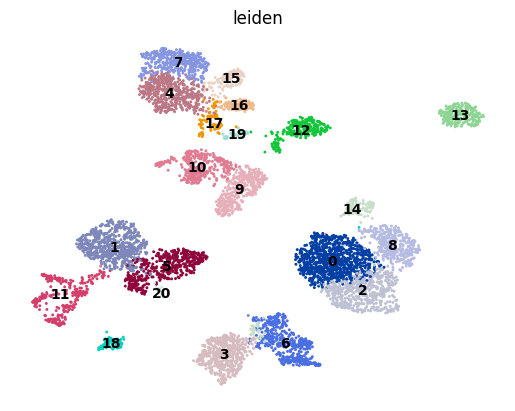

In [46]:
sc.pl.umap(adata, color = ['leiden'], frameon = False, legend_loc = "on data")

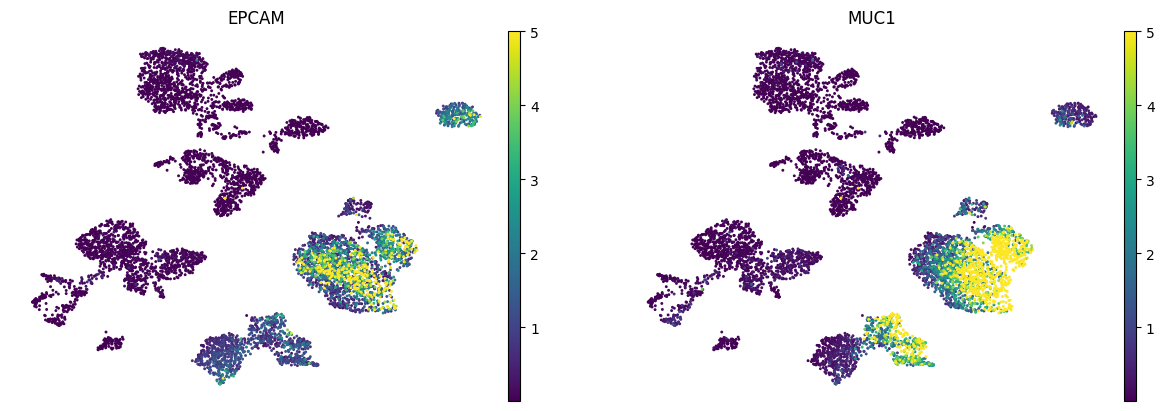

In [47]:
sc.pl.umap(adata, color = ['EPCAM', 'MUC1'], frameon = False, layer = 'scvi_normalized', vmax = 5)
#, layer = 'scvi_normalized'

In [48]:
cell_type = {"0":"Macrophage",
"1":"Fibroblast",
"2":"CD4+ T-cell",
"3":"AT2",
"4":"AT1",
"5":"CD8+ T-cell",
"6":"Endothelial cell",
"7":"Plasma cell",
"8":"Macrophage",
"9":"AT2",
"10":"Fibroblast",
"11":"Fibroblast",
"12":"Macrophage",
"13":"Macrophage",
"14":"Airway epithelial",
"15":"Airway epithelial",
"16":"Monocyte",
"17":"Airway epithelial",
"18":"B-cell",
"19":"Aerocyte",
"20":"Airway epithelial",
"21":"Smooth muscle cell",
"22":"Cycling T/NK",
"23":"Neuronal cell",
"24":"Denditic cell",
"25":"Pericyte",
"26":"Fibroblast",
"27":"Erythroid-like",
"28":"Macrophage"
}


In [49]:
adata.obs['cell type'] = adata.obs.leiden.map(cell_type)

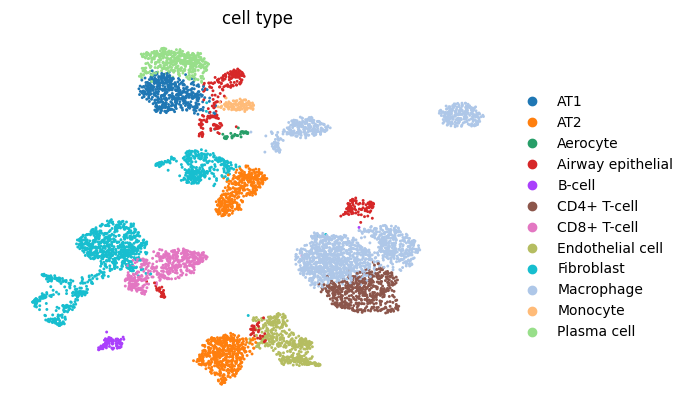

In [50]:
sc.pl.umap(adata, color = ['cell type'], frameon = False)

In [51]:
adata

AnnData object with n_obs × n_vars = 6856 × 10162
    obs: 'Sample', 'doublet', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', '_scvi_batch', '_scvi_labels', 'leiden', '_scvi_raw_norm_scaling', 'cell type'
    var: 'n_cells'
    uns: 'log1p', '_scvi_uuid', '_scvi_manager_uuid', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'Sample_colors', 'rank_genes_groups', 'cell type_colors'
    obsm: '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs', 'X_scVI', 'X_umap'
    layers: 'counts', 'scvi_normalized'
    obsp: 'distances', 'connectivities'

In [52]:
adata.uns['scvi_markers'] = markers_scvi
adata.uns['markers'] = markers

In [53]:
adata.write_h5ad('integrated.h5ad')

In [54]:
model.save('model.model')

# Analysis

In [55]:
import scanpy as sc
import scvi
import seaborn as sns
import numpy as np
import pandas as pd

## Counting cells

In [56]:
adata = sc.read_h5ad('integrated.h5ad')

In [57]:
adata.obs.Sample.unique().tolist()

['C56ctr', 'L01cov']

In [58]:
def map_condition(x):
    if 'cov' in x:
        return 'COVID19'
    else:
        return 'control'

In [59]:
adata.obs['condition'] = adata.obs.Sample.map(map_condition)
adata.obs

,Sample,doublet,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo,_scvi_batch,_scvi_labels,leiden,_scvi_raw_norm_scaling,cell type,condition
GCCCGAATCACTCGAA-1_6,C56ctr,False,2740,2740,6221.0,0.0,0.0,1.0,0.016075,0,0,2,1.668892,CD4+ T-cell,control
GAGTCATTCTGTCAGA-1_6,C56ctr,False,2426,2426,5828.0,0.0,0.0,0.0,0.000000,0,0,2,1.770538,CD4+ T-cell,control
GTTACGATCCAGTACA-1_6,C56ctr,False,2724,2724,6071.0,0.0,0.0,1.0,0.016472,0,0,0,1.713796,Macrophage,control
CCTGCATTCGGACAAG-1_6,C56ctr,False,2678,2678,5821.0,0.0,0.0,3.0,0.051538,0,0,6,1.798561,Endothelial cell,control
AGGGCTCTCATGCCCT-1_6,C56ctr,False,2742,2742,5527.0,0.0,0.0,0.0,0.000000,0,0,8,1.873361,Macrophage,control
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TATCCTACATCCAATG-1_8,L01cov,False,332,332,420.0,0.0,0.0,0.0,0.000000,0,0,13,25.575447,Macrophage,COVID19
CGTGATAGTTTCGTAG-1_8,L01cov,False,329,329,411.0,0.0,0.0,0.0,0.000000,0,0,19,25.316456,Aerocyte,COVID19
CTGTCGTTCTTTCTAG-1_8,L01cov,False,303,303,404.0,0.0,0.0,0.0,0.000000,0,0,3,25.575447,AT2,COVID19
GAGAAATTCATTGCGA-1_8,L01cov,False,305,305,405.0,0.0,0.0,0.0,0.000000,0,0,6,25.510204,Endothelial cell,COVID19


In [60]:
num_tot_cells = adata.obs.groupby(['Sample']).count()
num_tot_cells = dict(zip(num_tot_cells.index, num_tot_cells.doublet))
num_tot_cells

/tmp/ipykernel_3551/2419454245.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  num_tot_cells = adata.obs.groupby(['Sample']).count()


{'C56ctr': 3904, 'L01cov': 2952}

In [61]:
cell_type_counts = adata.obs.groupby(['Sample', 'condition', 'cell type']).count()
cell_type_counts = cell_type_counts[cell_type_counts.sum(axis = 1) > 0].reset_index()
cell_type_counts = cell_type_counts[cell_type_counts.columns[0:4]]
cell_type_counts

/tmp/ipykernel_3551/2058450824.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cell_type_counts = adata.obs.groupby(['Sample', 'condition', 'cell type']).count()


,Sample,condition,cell type,doublet
0,C56ctr,control,AT1,466
1,C56ctr,control,AT2,12
2,C56ctr,control,Aerocyte,18
3,C56ctr,control,Airway epithelial,48
4,C56ctr,control,B-cell,2
5,C56ctr,control,CD4+ T-cell,541
6,C56ctr,control,CD8+ T-cell,14
7,C56ctr,control,Endothelial cell,293
8,C56ctr,control,Fibroblast,933
9,C56ctr,control,Macrophage,1501


In [62]:
cell_type_counts['total_cells'] = cell_type_counts.Sample.map(num_tot_cells).astype(int)

cell_type_counts['frequency'] = cell_type_counts.doublet / cell_type_counts.total_cells

cell_type_counts

,Sample,condition,cell type,doublet,total_cells,frequency
0,C56ctr,control,AT1,466,3904,0.119365
1,C56ctr,control,AT2,12,3904,0.003074
2,C56ctr,control,Aerocyte,18,3904,0.004611
3,C56ctr,control,Airway epithelial,48,3904,0.012295
4,C56ctr,control,B-cell,2,3904,0.000512
5,C56ctr,control,CD4+ T-cell,541,3904,0.138576
6,C56ctr,control,CD8+ T-cell,14,3904,0.003586
7,C56ctr,control,Endothelial cell,293,3904,0.075051
8,C56ctr,control,Fibroblast,933,3904,0.238986
9,C56ctr,control,Macrophage,1501,3904,0.384477


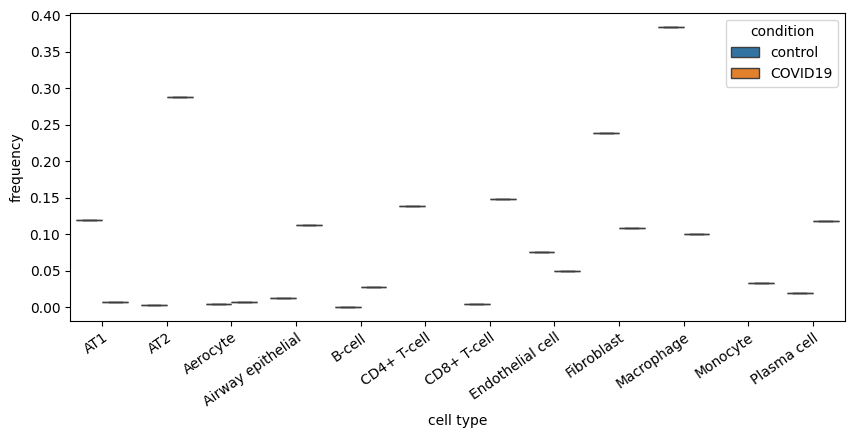

In [63]:
import matplotlib.pyplot as plt

plt.figure(figsize = (10,4))

ax = sns.boxplot(data = cell_type_counts, x = 'cell type', y = 'frequency', hue = 'condition')

plt.xticks(rotation = 35, rotation_mode = 'anchor', ha = 'right')

plt.show()


## DE

In [64]:
subset = adata[adata.obs['cell type'].isin(['AT1', 'AT2'])].copy()

In [ ]:
#two options: SCVI or diffxpy

In [65]:
!pip install diffxpy
!pip install dask==2021.4.0


/usr/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [66]:
import diffxpy.api as de

In [67]:
subset.X = subset.X.toarray()

In [68]:
len(subset.var)

10162

In [69]:
subset

AnnData object with n_obs × n_vars = 1348 × 10162
    obs: 'Sample', 'doublet', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', '_scvi_batch', '_scvi_labels', 'leiden', '_scvi_raw_norm_scaling', 'cell type', 'condition'
    var: 'n_cells'
    uns: 'Sample_colors', '_scvi_manager_uuid', '_scvi_uuid', 'cell type_colors', 'leiden', 'leiden_colors', 'log1p', 'markers', 'neighbors', 'rank_genes_groups', 'scvi_markers', 'umap'
    obsm: 'X_scVI', 'X_umap', '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs'
    layers: 'counts', 'scvi_normalized'
    obsp: 'connectivities', 'distances'

In [70]:
sc.pp.filter_genes(subset, min_cells=100)

In [71]:
len(subset.var)

2955

In [72]:
subset.obs = subset.obs.rename(columns = {'cell type':'cell_type'})

In [ ]:
#subset = subset.raw.to_adata() #need to run this if you scaled/regress your data and have negative numbers


In [73]:
subset.obs

,Sample,doublet,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo,_scvi_batch,_scvi_labels,leiden,_scvi_raw_norm_scaling,cell_type,condition
GACTGATGTCTGCGCA-1_6,C56ctr,False,2455,2455,4944.0,0.0,0.0,1.0,0.020227,0,0,4,2.111486,AT1,control
TCATGAGGTACAAGTA-1_6,C56ctr,False,2285,2285,4365.0,0.0,0.0,1.0,0.022910,0,0,4,2.410800,AT1,control
AAGTTCGCACCGTCGA-1_6,C56ctr,False,2520,2520,4515.0,0.0,0.0,76.0,1.683278,0,0,9,2.382654,AT2,control
ATCGGATGTTTGAACC-1_6,C56ctr,False,2170,2170,3845.0,0.0,0.0,0.0,0.000000,0,0,4,2.742732,AT1,control
AAGGTAATCCCTCTTT-1_6,C56ctr,False,2137,2137,3854.0,0.0,0.0,2.0,0.051894,0,0,4,2.733734,AT1,control
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ACGTAGTGTGGAAGTC-1_8,L01cov,False,351,351,429.0,0.0,0.0,1.0,0.233100,0,0,3,23.809525,AT2,COVID19
GCAGTTAAGCCAGAGT-1_8,L01cov,False,349,349,417.0,0.0,0.0,1.0,0.239808,0,0,9,25.316456,AT2,COVID19
GACTTCCTCGCATAGT-1_8,L01cov,False,340,340,409.0,0.0,0.0,3.0,0.733496,0,0,9,25.252525,AT2,COVID19
GAGGGTACAGGCAATG-1_8,L01cov,False,316,316,402.0,0.0,0.0,0.0,0.000000,0,0,3,25.839794,AT2,COVID19


In [74]:
#if want to test between covid/non covid
res = de.test.wald(data=subset,
              formula_loc= '~ 1 + condition',
              factor_loc_totest='condition'
                   )


#res = de.test.wald(data=subset,
#             formula_loc= '~ 1 + cell_type',
#             factor_loc_totest='cell_type'
#                 )

training location model: False
training scale model: True
iter   0: ll=4938883.421313
iter   1: ll=4938883.421313, converged: 0.00% (loc: 100.00%, scale update: False), in 0.00sec
Fitting 2955 dispersion models: (progress not available with multiprocessing)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


iter   2: ll=2906882.960441, converged: 0.03% (loc: 0.03%, scale update: True), in 3.16sec
iter   3: ll=2906882.960441, converged: 0.03% (loc: 100.00%, scale update: False), in 0.00sec
Fitting 2954 dispersion models: (progress not available with multiprocessing)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


iter   4: ll=2894072.715082, converged: 99.63% (loc: 99.63%, scale update: True), in 3.02sec
iter   5: ll=2894072.715082, converged: 99.63% (loc: 100.00%, scale update: False), in 0.00sec
Fitting 11 dispersion models: (progress not available with multiprocessing)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


iter   6: ll=2894048.414946, converged: 99.97% (loc: 99.97%, scale update: True), in 0.94sec
iter   7: ll=2894048.414946, converged: 99.97% (loc: 100.00%, scale update: False), in 0.00sec
iter   8: ll=2892782.860940, converged: 99.97% (loc: 99.97%, scale update: True), in 0.06sec
iter   9: ll=2892782.860940, converged: 99.97% (loc: 100.00%, scale update: False), in 0.00sec
iter  10: ll=2892782.860940, converged: 100.00% (loc: 100.00%, scale update: True), in 0.05sec


/home/sunag/.local/lib/python3.10/site-packages/dask/array/core.py:2894: RuntimeWarning: divide by zero encountered in divide
  size = (limit / dtype.itemsize / largest_block) ** (1 / len(autos))


In [75]:
dedf = res.summary().sort_values('log2fc', ascending = False).reset_index(drop = True)
dedf

,gene,pval,qval,log2fc,mean,zero_mean,grad,coef_mle,coef_sd,ll
0,CCBE1,0.000000e+00,0.000000e+00,283.913085,0.418263,False,3.086048e-01,283.913085,2.222759e-162,-3456.201270
1,LNX2,0.000000e+00,0.000000e+00,283.913085,0.368306,False,3.056384e-01,283.913085,2.222759e-162,-3369.534331
2,NRG1,0.000000e+00,0.000000e+00,283.913085,0.210298,False,6.347294e-01,283.913085,2.222759e-162,-775.444464
3,CTNND2,0.000000e+00,0.000000e+00,283.913085,0.235424,False,7.124906e-01,283.913085,2.222759e-162,-22.371740
4,HOPX,0.000000e+00,0.000000e+00,283.913085,0.223658,False,1.899104e-01,283.913085,2.222759e-162,-2086.731343
...,...,...,...,...,...,...,...,...,...,...
2950,GPNMB,5.195844e-14,2.589160e-13,-5.603398,0.207794,False,1.390999e-08,-5.603398,7.444704e-01,-477.325432
2951,ARHGAP22,0.000000e+00,0.000000e+00,-5.646497,0.286694,False,4.816593e-09,-5.646497,6.453711e-01,-593.585142
2952,NPL,3.996803e-14,2.005187e-13,-6.107447,0.286845,False,3.385423e-09,-6.107447,8.077672e-01,-586.674989
2953,AC093895.1,3.659295e-13,1.702869e-12,-6.209573,0.286239,False,2.697032e-08,-6.209573,8.544138e-01,-548.151315


In [76]:
subset.obs.cell_type.unique()

['AT1', 'AT2']
Categories (2, object): ['AT1', 'AT2']

In [77]:
most_up = dedf.iloc[0].gene
i = np.where(subset.var_names == most_up)[0][0]

a = subset[subset.obs.cell_type == 'AT1'].X[:, i]
b = subset[subset.obs.cell_type == 'AT2'].X[:, i]
print(f"{most_up} expression:")
print(f"AT1: {a.mean()}")
print(f"AT2: {b.mean()}")


CCBE1 expression:
AT1: 0.0
AT2: 0.6548407077789307


In [78]:
dedf['log2fc'] = dedf['log2fc']*-1
dedf = dedf.sort_values('log2fc', ascending = False).reset_index(drop = True)
dedf

,gene,pval,qval,log2fc,mean,zero_mean,grad,coef_mle,coef_sd,ll
0,STEAP1B,0.000000e+00,0.000000e+00,297.776029,0.200992,False,1.063847e-09,-297.776029,2.222759e-162,-448.034824
1,AC093895.1,3.659295e-13,1.702869e-12,6.209573,0.286239,False,2.697032e-08,-6.209573,8.544138e-01,-548.151315
2,NPL,3.996803e-14,2.005187e-13,6.107447,0.286845,False,3.385423e-09,-6.107447,8.077672e-01,-586.674989
3,ARHGAP22,0.000000e+00,0.000000e+00,5.646497,0.286694,False,4.816593e-09,-5.646497,6.453711e-01,-593.585142
4,GPNMB,5.195844e-14,2.589160e-13,5.603398,0.207794,False,1.390999e-08,-5.603398,7.444704e-01,-477.325432
...,...,...,...,...,...,...,...,...,...,...
2950,NRG3,0.000000e+00,0.000000e+00,-283.913085,0.515865,False,3.471806e-01,283.913085,2.222759e-162,-3936.418431
2951,GPM6A,0.000000e+00,0.000000e+00,-283.913085,0.510293,False,3.664682e-01,283.913085,2.222759e-162,-4120.036065
2952,COL12A1,0.000000e+00,0.000000e+00,-283.913085,0.549793,False,4.050445e-01,283.913085,2.222759e-162,-4538.022772
2953,FILIP1,0.000000e+00,0.000000e+00,-283.913085,0.317806,False,2.537086e-01,283.913085,2.222759e-162,-2811.001547


In [79]:
dedf = dedf[(dedf.qval < 0.05) & (abs(dedf.log2fc) > .5)]
dedf

,gene,pval,qval,log2fc,mean,zero_mean,grad,coef_mle,coef_sd,ll
0,STEAP1B,0.000000e+00,0.000000e+00,297.776029,0.200992,False,1.063847e-09,-297.776029,2.222759e-162,-448.034824
1,AC093895.1,3.659295e-13,1.702869e-12,6.209573,0.286239,False,2.697032e-08,-6.209573,8.544138e-01,-548.151315
2,NPL,3.996803e-14,2.005187e-13,6.107447,0.286845,False,3.385423e-09,-6.107447,8.077672e-01,-586.674989
3,ARHGAP22,0.000000e+00,0.000000e+00,5.646497,0.286694,False,4.816593e-09,-5.646497,6.453711e-01,-593.585142
4,GPNMB,5.195844e-14,2.589160e-13,5.603398,0.207794,False,1.390999e-08,-5.603398,7.444704e-01,-477.325432
...,...,...,...,...,...,...,...,...,...,...
2950,NRG3,0.000000e+00,0.000000e+00,-283.913085,0.515865,False,3.471806e-01,283.913085,2.222759e-162,-3936.418431
2951,GPM6A,0.000000e+00,0.000000e+00,-283.913085,0.510293,False,3.664682e-01,283.913085,2.222759e-162,-4120.036065
2952,COL12A1,0.000000e+00,0.000000e+00,-283.913085,0.549793,False,4.050445e-01,283.913085,2.222759e-162,-4538.022772
2953,FILIP1,0.000000e+00,0.000000e+00,-283.913085,0.317806,False,2.537086e-01,283.913085,2.222759e-162,-2811.001547


In [80]:
dedf = dedf[dedf['mean'] > 0.15]
dedf

,gene,pval,qval,log2fc,mean,zero_mean,grad,coef_mle,coef_sd,ll
0,STEAP1B,0.000000e+00,0.000000e+00,297.776029,0.200992,False,1.063847e-09,-297.776029,2.222759e-162,-448.034824
1,AC093895.1,3.659295e-13,1.702869e-12,6.209573,0.286239,False,2.697032e-08,-6.209573,8.544138e-01,-548.151315
2,NPL,3.996803e-14,2.005187e-13,6.107447,0.286845,False,3.385423e-09,-6.107447,8.077672e-01,-586.674989
3,ARHGAP22,0.000000e+00,0.000000e+00,5.646497,0.286694,False,4.816593e-09,-5.646497,6.453711e-01,-593.585142
4,GPNMB,5.195844e-14,2.589160e-13,5.603398,0.207794,False,1.390999e-08,-5.603398,7.444704e-01,-477.325432
...,...,...,...,...,...,...,...,...,...,...
2950,NRG3,0.000000e+00,0.000000e+00,-283.913085,0.515865,False,3.471806e-01,283.913085,2.222759e-162,-3936.418431
2951,GPM6A,0.000000e+00,0.000000e+00,-283.913085,0.510293,False,3.664682e-01,283.913085,2.222759e-162,-4120.036065
2952,COL12A1,0.000000e+00,0.000000e+00,-283.913085,0.549793,False,4.050445e-01,283.913085,2.222759e-162,-4538.022772
2953,FILIP1,0.000000e+00,0.000000e+00,-283.913085,0.317806,False,2.537086e-01,283.913085,2.222759e-162,-2811.001547


In [81]:
genes_to_show = dedf[-25:].gene.tolist() + dedf[:25].gene.tolist() #top 25 and bottom 25 from sorted df

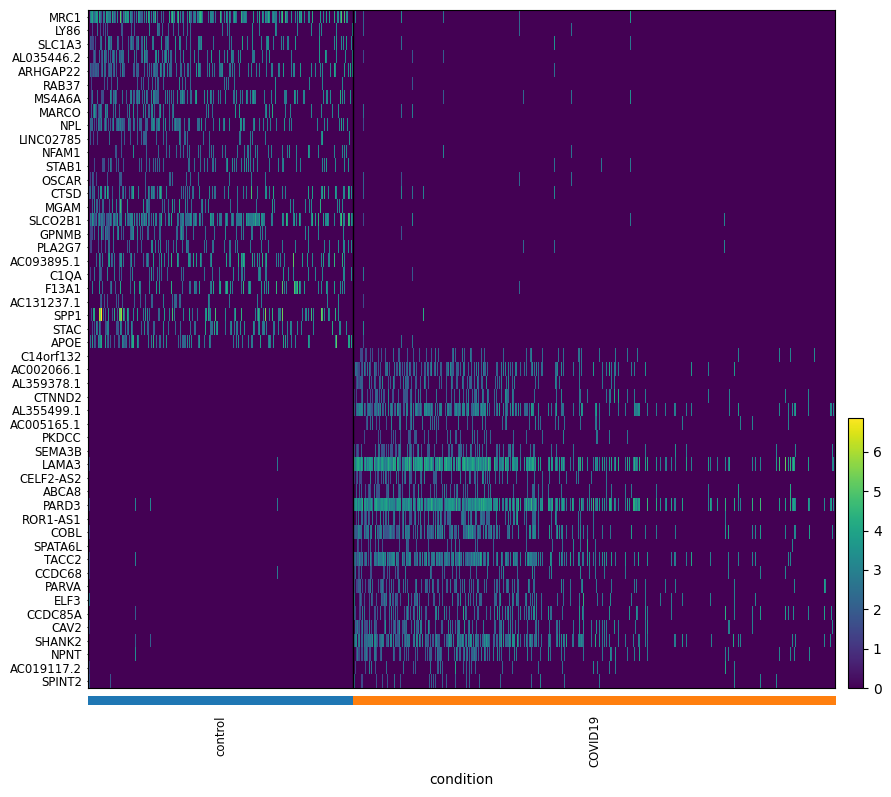

In [178]:
sc.pl.heatmap(subset, genes_to_show, groupby='condition', swap_axes=True)

# GO enrichment

In [158]:
!pip install gseapy

/usr/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 552.9/552.9 KB 3.3 MB/s eta 0:00:00a 0:00:01


In [159]:
import gseapy as gp #this method requires internet connection

In [160]:
gp.get_library_name()
# 'GO_Biological_Process_2021',
#'KEGG_2021_Human',

['ARCHS4_Cell-lines',
 'ARCHS4_IDG_Coexp',
 'ARCHS4_Kinases_Coexp',
 'ARCHS4_TFs_Coexp',
 'ARCHS4_Tissues',
 'Achilles_fitness_decrease',
 'Achilles_fitness_increase',
 'Aging_Perturbations_from_GEO_down',
 'Aging_Perturbations_from_GEO_up',
 'Allen_Brain_Atlas_10x_scRNA_2021',
 'Allen_Brain_Atlas_down',
 'Allen_Brain_Atlas_up',
 'Azimuth_2023',
 'Azimuth_Cell_Types_2021',
 'BioCarta_2013',
 'BioCarta_2015',
 'BioCarta_2016',
 'BioPlanet_2019',
 'BioPlex_2017',
 'CCLE_Proteomics_2020',
 'CORUM',
 'COVID-19_Related_Gene_Sets',
 'COVID-19_Related_Gene_Sets_2021',
 'Cancer_Cell_Line_Encyclopedia',
 'CellMarker_2024',
 'CellMarker_Augmented_2021',
 'ChEA_2013',
 'ChEA_2015',
 'ChEA_2016',
 'ChEA_2022',
 'Chromosome_Location',
 'Chromosome_Location_hg19',
 'ClinVar_2019',
 'DSigDB',
 'Data_Acquisition_Method_Most_Popular_Genes',
 'DepMap_WG_CRISPR_Screens_Broad_CellLines_2019',
 'DepMap_WG_CRISPR_Screens_Sanger_CellLines_2019',
 'Descartes_Cell_Types_and_Tissue_2021',
 'Diabetes_Perturbatio

In [161]:
subset

AnnData object with n_obs × n_vars = 1348 × 2955
    obs: 'Sample', 'doublet', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', '_scvi_batch', '_scvi_labels', 'leiden', '_scvi_raw_norm_scaling', 'cell_type', 'condition', 'genes'
    var: 'index', 'n_cells'
    uns: 'Sample_colors', '_scvi_manager_uuid', '_scvi_uuid', 'cell type_colors', 'leiden', 'leiden_colors', 'log1p', 'markers', 'neighbors', 'rank_genes_groups', 'scvi_markers', 'umap', 'cell_type_colors'
    obsm: 'X_scVI', 'X_umap', '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs'
    layers: 'counts', 'scvi_normalized'
    obsp: 'connectivities', 'distances'

In [167]:
subset

AnnData object with n_obs × n_vars = 1348 × 2955
    obs: 'Sample', 'doublet', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', '_scvi_batch', '_scvi_labels', 'leiden', '_scvi_raw_norm_scaling', 'cell_type', 'condition', 'genes'
    var: 'index', 'n_cells'
    uns: 'Sample_colors', '_scvi_manager_uuid', '_scvi_uuid', 'cell type_colors', 'leiden', 'leiden_colors', 'log1p', 'markers', 'neighbors', 'rank_genes_groups', 'scvi_markers', 'umap', 'cell_type_colors'
    obsm: 'X_scVI', 'X_umap', '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs'
    layers: 'counts', 'scvi_normalized'
    obsp: 'connectivities', 'distances'

In [168]:
enr = gp.enrichr(gene_list= dedf[dedf.log2fc > 0].gene.tolist(),
                 gene_sets=['KEGG_2021_Human','GO_Biological_Process_2021'],
                 organism='human', # don't forget to set organism to the one you desired!
                 outdir=None, # don't write to disk,
                 background = subset.var['index'].tolist()
                )

In [169]:
enr.results

,Gene_set,Term,P-value,Adjusted P-value,Old P-value,Old adjusted P-value,Odds Ratio,Combined Score,Genes
0,KEGG_2021_Human,Lysosome,1.865324e-09,5.185601e-07,0,0,8.432115,169.484084,SCARB2;ASAH1;CLTC;CTSZ;HEXA;GNS;LITAF;CTSS;GGA...
1,KEGG_2021_Human,Phagosome,7.470136e-08,1.038349e-05,0,0,5.826772,95.615981,ATP6V1A;COLEC12;TFRC;STX18;CTSS;LAMP1;CLEC7A;M...
2,KEGG_2021_Human,Rheumatoid arthritis,2.605221e-05,2.414172e-03,0,0,7.753017,81.836254,CD86;ATP6V1A;HLA-DRB5;IL15;HLA-DPB1;ATP6V1H;HL...
3,KEGG_2021_Human,Asthma,9.829886e-05,6.831771e-03,0,0,inf,inf,HLA-DRB5;HLA-DPB1;HLA-DRA;HLA-DQA1;HLA-DRB1;HL...
4,KEGG_2021_Human,Staphylococcus aureus infection,2.222683e-04,9.222337e-03,0,0,12.397959,104.286987,HLA-DRB5;FCGR2A;HLA-DPB1;HLA-DRA;FPR3;HLA-DQA1...
...,...,...,...,...,...,...,...,...,...
3765,GO_Biological_Process_2021,regulation of RNA splicing (GO:0043484),9.999545e-01,9.999810e-01,0,0,0.086795,0.000004,SETX
3766,GO_Biological_Process_2021,negative regulation of cellular macromolecule ...,9.999717e-01,9.999810e-01,0,0,0.398742,0.000011,RB1;TCF7L2;PHC2;CIITA;DAPK1;ATP8B1;SFMBT2;FOXN...
3767,GO_Biological_Process_2021,mRNA processing (GO:0006397),9.999744e-01,9.999810e-01,0,0,0.266158,0.000007,RSRC1;RNMT;CWF19L2;THOC1;GTF2F2;CTNNBL1;U2SURP
3768,GO_Biological_Process_2021,"mRNA splicing, via spliceosome (GO:0000398)",9.999773e-01,9.999810e-01,0,0,0.222293,0.000005,RSRC1;CWF19L2;GTF2F2;CTNNBL1;U2SURP


## comparisons

In [174]:
subset.obs = subset.obs.drop(columns=['genes'])
subset.obs

,Sample,doublet,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo,_scvi_batch,_scvi_labels,leiden,_scvi_raw_norm_scaling,cell_type,condition
GACTGATGTCTGCGCA-1_6,C56ctr,False,2455,2455,4944.0,0.0,0.0,1.0,0.020227,0,0,4,2.111486,AT1,control
TCATGAGGTACAAGTA-1_6,C56ctr,False,2285,2285,4365.0,0.0,0.0,1.0,0.022910,0,0,4,2.410800,AT1,control
AAGTTCGCACCGTCGA-1_6,C56ctr,False,2520,2520,4515.0,0.0,0.0,76.0,1.683278,0,0,9,2.382654,AT2,control
ATCGGATGTTTGAACC-1_6,C56ctr,False,2170,2170,3845.0,0.0,0.0,0.0,0.000000,0,0,4,2.742732,AT1,control
AAGGTAATCCCTCTTT-1_6,C56ctr,False,2137,2137,3854.0,0.0,0.0,2.0,0.051894,0,0,4,2.733734,AT1,control
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ACGTAGTGTGGAAGTC-1_8,L01cov,False,351,351,429.0,0.0,0.0,1.0,0.233100,0,0,3,23.809525,AT2,COVID19
GCAGTTAAGCCAGAGT-1_8,L01cov,False,349,349,417.0,0.0,0.0,1.0,0.239808,0,0,9,25.316456,AT2,COVID19
GACTTCCTCGCATAGT-1_8,L01cov,False,340,340,409.0,0.0,0.0,3.0,0.733496,0,0,9,25.252525,AT2,COVID19
GAGGGTACAGGCAATG-1_8,L01cov,False,316,316,402.0,0.0,0.0,0.0,0.000000,0,0,3,25.839794,AT2,COVID19


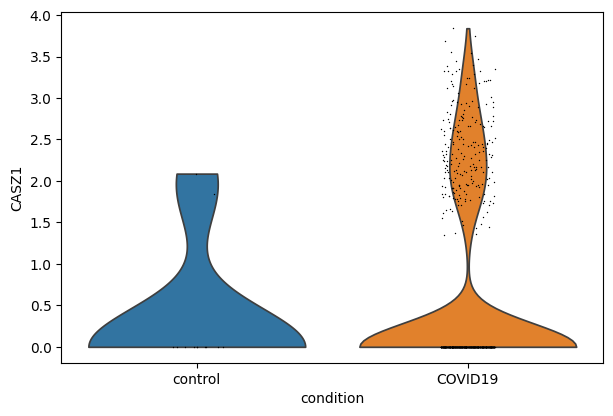

In [195]:
sc.pl.violin(subset[subset.obs.cell_type == 'AT2'], 'CASZ1', groupby='condition')

In [176]:
from scipy import stats

In [197]:
temp = subset[subset.obs.cell_type == 'AT2']

In [199]:
temp = subset[subset.obs.cell_type == 'AT2']

i = np.where(temp.var['index'] == 'CASZ1')[0][0]

In [200]:
a = temp[temp.obs.condition == 'COVID19'].X[:,i]
b = temp[temp.obs.condition == 'control'].X[:,i]

In [201]:
stats.mannwhitneyu(a, b)

MannwhitneyuResult(statistic=5730.0, pvalue=0.3400974376370527)

## Score gene signature

In [206]:
#gene signature, ie, input list of genes from user
with open('/home/sunag/datp_sig.txt') as f:
    datp_sig = list(set([x.strip().split(',')[0] for x in list(f)]))


In [209]:
sc.tl.score_genes(subset, datp_sig, score_name = 'datp')

In [210]:
subset.obs

,Sample,doublet,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo,_scvi_batch,_scvi_labels,leiden,_scvi_raw_norm_scaling,cell_type,condition,datp
GACTGATGTCTGCGCA-1_6,C56ctr,False,2455,2455,4944.0,0.0,0.0,1.0,0.020227,0,0,4,2.111486,AT1,control,-0.021905
TCATGAGGTACAAGTA-1_6,C56ctr,False,2285,2285,4365.0,0.0,0.0,1.0,0.022910,0,0,4,2.410800,AT1,control,0.189675
AAGTTCGCACCGTCGA-1_6,C56ctr,False,2520,2520,4515.0,0.0,0.0,76.0,1.683278,0,0,9,2.382654,AT2,control,0.831465
ATCGGATGTTTGAACC-1_6,C56ctr,False,2170,2170,3845.0,0.0,0.0,0.0,0.000000,0,0,4,2.742732,AT1,control,0.090255
AAGGTAATCCCTCTTT-1_6,C56ctr,False,2137,2137,3854.0,0.0,0.0,2.0,0.051894,0,0,4,2.733734,AT1,control,-0.102803
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ACGTAGTGTGGAAGTC-1_8,L01cov,False,351,351,429.0,0.0,0.0,1.0,0.233100,0,0,3,23.809525,AT2,COVID19,0.241812
GCAGTTAAGCCAGAGT-1_8,L01cov,False,349,349,417.0,0.0,0.0,1.0,0.239808,0,0,9,25.316456,AT2,COVID19,-0.097334
GACTTCCTCGCATAGT-1_8,L01cov,False,340,340,409.0,0.0,0.0,3.0,0.733496,0,0,9,25.252525,AT2,COVID19,0.056389
GAGGGTACAGGCAATG-1_8,L01cov,False,316,316,402.0,0.0,0.0,0.0,0.000000,0,0,3,25.839794,AT2,COVID19,0.282052


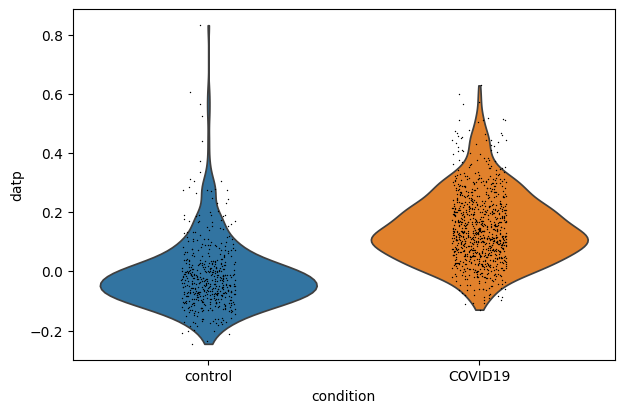

In [211]:
sc.pl.violin(subset, 'datp', groupby='condition')

In [212]:
a = subset[subset.obs.condition == 'COVID19'].obs.datp.values
b = subset[subset.obs.condition == 'control'].obs.datp.values
stats.mannwhitneyu(a, b)

MannwhitneyuResult(statistic=357282.0, pvalue=8.9774560645262e-106)

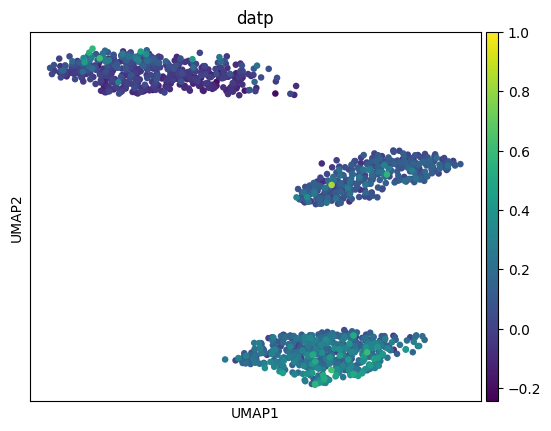

In [213]:
sc.pl.umap(subset, color = 'datp', vmax = 1)